 # Setup, Pre-processing, and data cleaning


In [1]:
import warnings
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore")
import requests
import random 
import os


In [2]:
SEED = 42
random.seed(SEED)

np.random.seed(SEED)

import sklearn
sklearn.utils.check_random_state(SEED)

os.environ["PYTHONHASHSEED"] = str(SEED)

In [3]:
# ----------------------------------------------------------
# Load data from local copy of cs_bisnode_panel.csv
# ----------------------------------------------------------
url = "https://osf.io/7s5yb/download?version=1"
response = requests.get(url)
df = pd.read_csv(StringIO(response.text))
# Initial inspection
info = df.info()
head = df.head()
columns = df.columns.tolist()

desc = df.describe(include='all')

df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287829 entries, 0 to 287828
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   comp_id               287829 non-null  float64
 1   begin                 287829 non-null  object 
 2   end                   287829 non-null  object 
 3   COGS                  18257 non-null   float64
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  finished_prod         17485 non-null   float64
 11  fixed_assets          287698 non-null  float64
 12  inc_bef_tax           280392 non-null  float64
 13  intang_assets         287689 non-null  float64
 14  inventories           287698 non-null  float64
 15  

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1.001034e+06,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1.001034e+06,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1.001034e+06,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1.001034e+06,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1.001034e+06,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287824,4.641209e+11,2011-01-01,2011-12-31,NaN,0.000000,1807.407349,3.703704,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287825,4.641209e+11,2012-01-01,2012-12-31,NaN,0.000000,1518.518555,96.296295,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287826,4.641209e+11,2013-01-01,2013-12-31,NaN,0.000000,988.888916,77.777779,0.0,0.0,0.0,...,NaN,NaN,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287827,4.641209e+11,2014-01-01,2014-12-31,NaN,0.000000,644.444458,233.333328,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN


In [4]:
print(df["year"].min(), "→", df["year"].max())

2005 → 2016


In [5]:

# Convert year to integer and restrict panel to 2010–2015
df['year'] = df['year'].astype(int)
df = df[(df['year'] >= 2010) & (df['year'] <= 2015)].copy()

# Drop sparse or redundant columns
df = df.drop(columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"], errors='ignore')

# ----------------------------------------------------------
# Create lagged variables and filter based on exit status
# ----------------------------------------------------------
# Sort for consistency
df.sort_values(by=['comp_id', 'year'], inplace=True)
# Generate t+1 values for growth computation
df['sales_next'] = df.groupby('comp_id')['sales'].shift(-1)
df['labor_next'] = df.groupby('comp_id')['labor_avg'].shift(-1)
df['year_next'] = df.groupby('comp_id')['year'].shift(-1)
df['exit_year'] = pd.to_numeric(df['exit_year'], errors='coerce')
# Drop firms that exited before t+1
df = df[
    (df['exit_year'].isna()) | (df['exit_year'] > df['year'])
]
# Drop rows without valid sales data for t and t+1
df_clean = df.dropna(subset=['sales', 'sales_next'])
df_clean["sales"] = pd.to_numeric(df["sales"], errors="coerce")
df_clean["sales_next"] = pd.to_numeric(df["sales_next"], errors="coerce")

df_clean


,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,...,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg,sales_next,labor_next,year_next
5,1.001034e+06,2010-01-01,2010-12-31,177.777771,2096.296387,19629.628906,0.0,0.0,0.0,637.037048,...,56.0,3.0,1,Central,1990-11-19,NaN,0.083333,0.000000,0.083333,2011.0
6,1.001034e+06,2011-01-01,2011-12-31,155.555557,3607.407471,22555.554688,0.0,0.0,0.0,481.481476,...,56.0,3.0,1,Central,1990-11-19,NaN,0.083333,0.000000,0.083333,2012.0
7,1.001034e+06,2012-01-01,2012-12-31,140.740738,148.148148,21429.628906,0.0,0.0,0.0,340.740753,...,56.0,3.0,1,Central,1990-11-19,NaN,0.083333,0.000000,NaN,2013.0
8,1.001034e+06,2013-01-01,2013-12-31,140.740738,140.740738,21851.851562,0.0,0.0,0.0,200.000000,...,56.0,3.0,1,Central,1990-11-19,NaN,NaN,0.000000,NaN,2014.0
9,1.001034e+06,2014-01-01,2014-12-31,29.629629,144.444443,22340.740234,0.0,0.0,0.0,170.370377,...,56.0,3.0,1,Central,1990-11-19,NaN,NaN,0.000000,NaN,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287823,4.641209e+11,2010-01-01,2010-12-31,0.000000,1781.481445,0.000000,0.0,0.0,0.0,0.000000,...,55.0,3.0,2,East,1990-08-22,NaN,NaN,288.888885,NaN,2011.0
287824,4.641209e+11,2011-01-01,2011-12-31,0.000000,1807.407349,3.703704,0.0,0.0,0.0,0.000000,...,55.0,3.0,2,East,1990-08-22,NaN,NaN,0.000000,NaN,2012.0
287825,4.641209e+11,2012-01-01,2012-12-31,0.000000,1518.518555,96.296295,0.0,0.0,0.0,0.000000,...,55.0,3.0,2,East,1990-08-22,NaN,NaN,0.000000,NaN,2013.0
287826,4.641209e+11,2013-01-01,2013-12-31,0.000000,988.888916,77.777779,0.0,0.0,0.0,0.000000,...,55.0,3.0,2,East,1990-08-22,NaN,NaN,0.000000,NaN,2014.0


# PART I: Target Variable Construction – Fast Growth

In [6]:
# Filter for 2012 as base year for 1-year growth
df_growth = df_clean[(df_clean['year'] == 2012) & (~df_clean['sales_next'].isna())]
df_growth = df_growth[(df_growth['exit_year'].isna()) | (df_growth['exit_year'] > 2013)]
# Remove firms with zero sales in base year
df_growth = df_growth[df_growth["sales"] != 0]

# Compute sales growth and remove outliers
df_growth['sales_growth'] = (df_growth['sales_next'] / df_growth['sales']) - 1
df_growth = df_growth[(df_growth['sales_growth'] > -1) & (df_growth['sales_growth'] < 10)]

# Define binary target: top 10% = fast growth
growth_threshold = df_growth['sales_growth'].quantile(0.90)
df_growth['fast_growth_sales'] = (df_growth['sales_growth'] >= growth_threshold).astype(int)
df_growth

,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,...,urban_m,region_m,founded_date,exit_date,labor_avg,sales_next,labor_next,year_next,sales_growth,fast_growth_sales
14,1.001541e+06,2012-01-01,2012-12-31,481.481476,9.629630e+03,1.303704e+03,0.000000,0.000000,0.000000,190566.671875,...,3,Central,2008-02-24,NaN,NaN,5.555556e+03,NaN,2013.0,3.615385,1
23,1.002029e+06,2012-01-01,2012-12-31,14929.629883,2.038852e+05,1.204445e+05,0.000000,0.000000,0.000000,23459.259766,...,3,East,2006-07-03,NaN,0.458333,3.580630e+05,0.437500,2013.0,-0.684947,0
56,1.011889e+06,2012-01-01,2012-12-31,36625.925781,1.601667e+05,1.891111e+04,0.000000,0.000000,0.000000,933574.062500,...,2,West,1992-11-09,NaN,1.621212,4.420333e+05,1.583333,2013.0,0.019293,0
68,1.014183e+06,2012-01-01,2012-12-31,12551.851562,1.999037e+05,8.274074e+03,0.000000,7.407407,7.407407,118229.632812,...,2,Central,2001-12-21,NaN,0.715278,1.162111e+05,0.819444,2013.0,-0.104205,0
80,1.018301e+06,2012-01-01,2012-12-31,0.000000,1.811111e+03,5.925926e+02,0.000000,11.111111,11.111111,52155.554688,...,2,Central,2004-06-29,NaN,0.152778,8.448148e+03,0.166667,2013.0,0.256749,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287764,4.638854e+11,2012-01-01,2012-12-31,544.444458,1.437407e+04,1.330000e+04,0.000000,0.000000,0.000000,7985.185059,...,3,East,2009-02-25,NaN,0.121212,3.693444e+05,0.083333,2013.0,1.365346,1
287779,4.639820e+11,2012-01-01,2012-12-31,16337.037109,3.140000e+04,8.300000e+03,0.000000,0.000000,0.000000,113266.656250,...,1,Central,1995-05-14,NaN,0.548611,3.701926e+05,0.506944,2013.0,0.939912,0
287790,4.640212e+11,2012-01-01,2012-12-31,3566.666748,3.149630e+04,1.783704e+04,0.000000,0.000000,0.000000,31707.408203,...,2,Central,2006-05-09,NaN,0.083333,5.832222e+04,0.083333,2013.0,0.532853,0
287798,4.640446e+11,2012-01-01,2012-12-31,76059.257812,4.776548e+06,1.297552e+06,0.000000,0.000000,0.000000,286355.562500,...,3,Central,2008-10-09,NaN,1.840278,8.638381e+06,1.993056,2013.0,0.012234,0


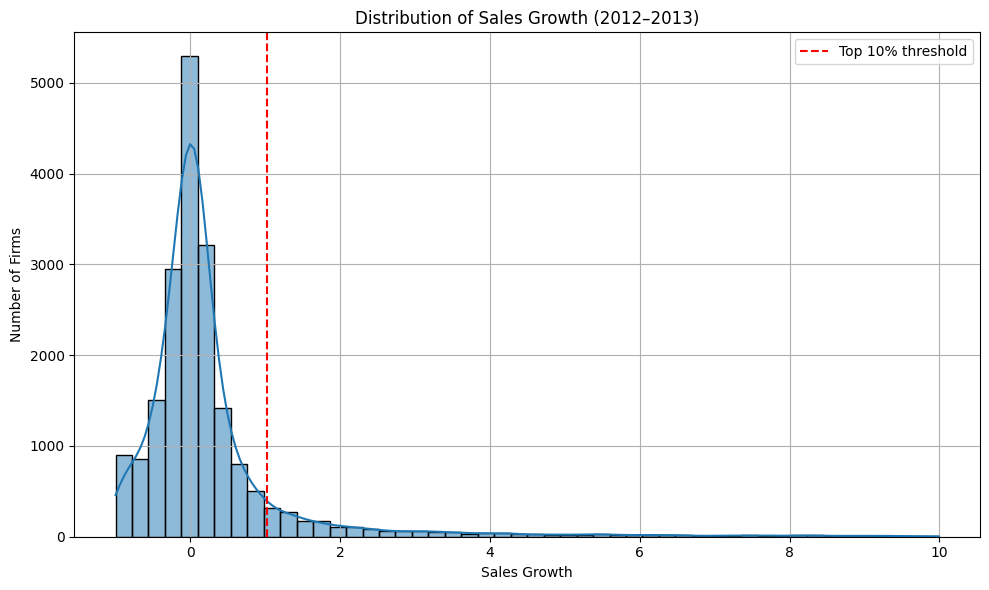

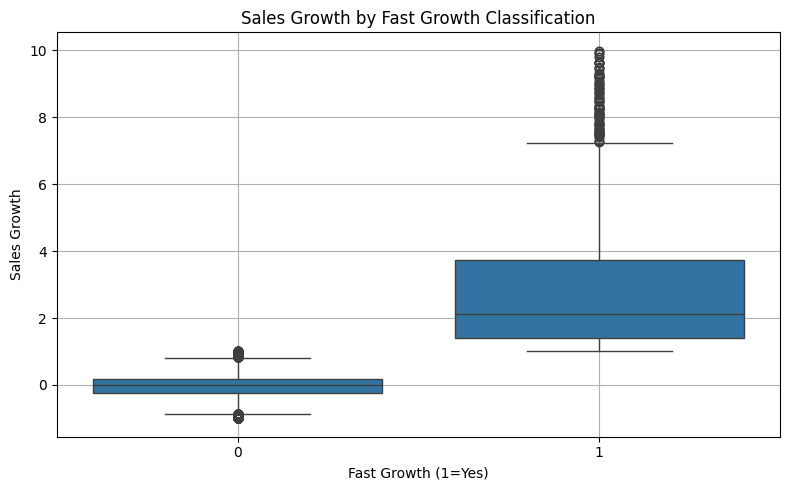

In [7]:
# ----------------------------------------------------------
# Visualize Target Variable Distribution
# ----------------------------------------------------------

plt.figure(figsize=(10, 6))
sns.histplot(df_growth['sales_growth'], bins=50, kde=True)
plt.axvline(growth_threshold, color='red', linestyle='--', label='Top 10% threshold')
plt.title('Distribution of Sales Growth (2012–2013)')
plt.xlabel('Sales Growth')
plt.ylabel('Number of Firms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x='fast_growth_sales', y='sales_growth', data=df_growth)
plt.title('Sales Growth by Fast Growth Classification')
plt.xlabel('Fast Growth (1=Yes)')
plt.ylabel('Sales Growth')
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# ----------------------------------------------------------
# Summary statistics by growth class
# ----------------------------------------------------------
summary_stats = df_growth.groupby('fast_growth_sales')['sales_growth'].describe()
summary_stats

,count,mean,std,min,25%,50%,75%,max
fast_growth_sales,,,,,,,,
0,17501.0,-0.026828,0.395133,-0.999920,-0.234542,-0.003367,0.186732,1.016830
1,1945.0,2.932783,2.075946,1.017191,1.400000,2.109517,3.730290,9.992043


In [9]:
# ----------------------------------------------------------
# separate dataframes for modelling and post-modeling evaluations
# ----------------------------------------------------------
df_full = df.copy()  # Keep all variables
# Keep final feature and control set
columns_to_keep = [
    'comp_id', 'year', 'sales', 'labor_avg', 'sales_next', 'sales_growth', 'fast_growth_sales',
    'nace_main', 'ind2', 'region_m', 'urban_m',
    'foreign', 'female', 'ceo_count', 'inoffice_days'
]
df_model = df_growth[columns_to_keep].copy()  # Use for modeling

In [10]:
#-----------------------------------------------------------
# Data Cleaning
#-----------------------------------------------------------
# Drop rows missing target-defining variables
df_model = df_model.dropna(subset=['sales', 'sales_next', 'sales_growth'])

# Impute missing categorical controls
df_model['region_m'] = df_model['region_m'].fillna('Unknown')
df_model['nace_main'] = df_model['nace_main'].fillna(-1)

# Impute numeric controls and add missingness flags
for col in ['foreign', 'female', 'ceo_count', 'inoffice_days']:
    df_model[f'{col}_missing'] = df_model[col].isna().astype(int)
    df_model[col] = df_model[col].fillna(df_model[col].median())
# Final overview
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19446 entries, 14 to 287814
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   comp_id                19446 non-null  float64
 1   year                   19446 non-null  int64  
 2   sales                  19446 non-null  float64
 3   labor_avg              16644 non-null  float64
 4   sales_next             19446 non-null  float64
 5   sales_growth           19446 non-null  float64
 6   fast_growth_sales      19446 non-null  int64  
 7   nace_main              19446 non-null  float64
 8   ind2                   19440 non-null  float64
 9   region_m               19446 non-null  object 
 10  urban_m                19446 non-null  int64  
 11  foreign                19446 non-null  float64
 12  female                 19446 non-null  float64
 13  ceo_count              19446 non-null  float64
 14  inoffice_days          19446 non-null  float64
 15  forei

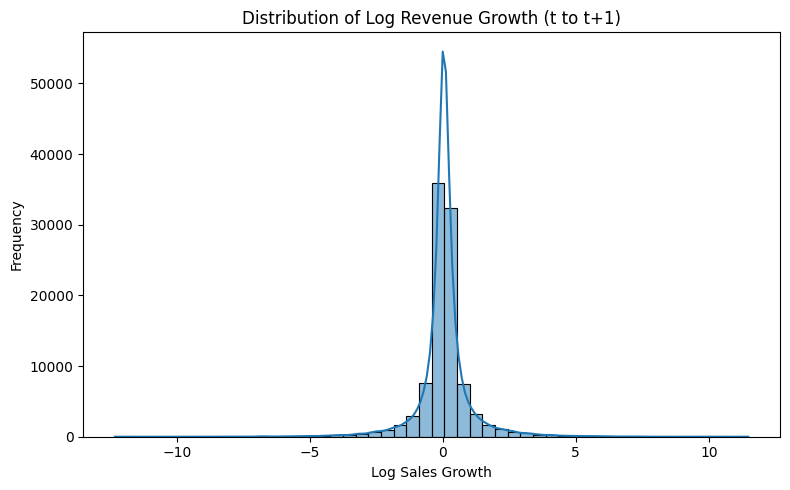

,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,...,ind,urban_m,region_m,founded_date,exit_date,labor_avg,sales_next,labor_next,year_next,log_sales_growth
5,1001034.0,2010-01-01,2010-12-31,177.777771,2096.296387,19629.628906,0.0,0.0,0.0,637.037048,...,3.0,1,Central,1990-11-19,NaN,0.083333,0.0,0.083333,2011.0,-inf
6,1001034.0,2011-01-01,2011-12-31,155.555557,3607.407471,22555.554688,0.0,0.0,0.0,481.481476,...,3.0,1,Central,1990-11-19,NaN,0.083333,0.0,0.083333,2012.0,NaN
7,1001034.0,2012-01-01,2012-12-31,140.740738,148.148148,21429.628906,0.0,0.0,0.0,340.740753,...,3.0,1,Central,1990-11-19,NaN,0.083333,0.0,NaN,2013.0,NaN
8,1001034.0,2013-01-01,2013-12-31,140.740738,140.740738,21851.851562,0.0,0.0,0.0,200.000000,...,3.0,1,Central,1990-11-19,NaN,NaN,0.0,NaN,2014.0,NaN
9,1001034.0,2014-01-01,2014-12-31,29.629629,144.444443,22340.740234,0.0,0.0,0.0,170.370377,...,3.0,1,Central,1990-11-19,NaN,NaN,0.0,NaN,2015.0,NaN


In [11]:

df_clean['log_sales_growth'] = np.log(df_clean['sales_next'] / df_clean['sales'])

plt.figure(figsize=(8, 5))
sns.histplot(df_clean['log_sales_growth'], bins=50, kde=True)
plt.title("Distribution of Log Revenue Growth (t to t+1)")
plt.xlabel("Log Sales Growth")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

df_clean.head()


## Constructing Alternative Fast-Growth Targets

To evaluate the robustness of our firm growth prediction models, we construct three distinct binary target variables based on sales growth over time:

1. **1-Year Sales Growth (2012–2013)**: Captures short-run momentum. It is sensitive to temporary shocks and may be influenced by year-specific conditions.
2. **2-Year Compound Annual Growth Rate (CAGR, 2012–2014)**: Captures sustained growth over time. It smooths year-to-year volatility and better reflects long-term business expansion.
3. **Log Sales Growth (2012–2013)**: Accounts for proportional growth and is more robust to extreme values. Often used in econometric models for its interpretability and distributional properties.

By comparing model performance across these three definitions, we aim to identify which growth indicator yields the most predictable and stable signals of "fast growth" among firms. This strategy helps ensure that our final model choice is not overly dependent on a single target definition, enhancing both credibility and generalizability of our findings.


In [12]:
# === Step 1: Extract relevant columns for growth computation ===
df_sales = df_clean[["comp_id", "year", "sales", "exit_year"]].copy()

# Step 2: Filter to key years for growth (2012, 2013, 2014)
df_sales = df_sales[df_sales["year"].isin([2012, 2013, 2014])]

# Step 3: Pivot to wide format for sales
sales_pivot = df_sales.pivot(index="comp_id", columns="year", values="sales")

# Step 4: Filter to active firms (not exited before 2014)
exit_info = df_clean.groupby("comp_id")["exit_year"].first()
active_firms = exit_info[(exit_info.isna()) | (exit_info >= 2014)].index
sales_pivot = sales_pivot.loc[sales_pivot.index.isin(active_firms)]


### Feasibility of CAGR as a Target Variable

To ensure the reliability of CAGR (Compound Annual Growth Rate) as a target, we examined data availability across years. Out of 25,044 firms with non-missing sales data in 2012, 21,315 (85.11%) had valid observations in both 2012 and 2014 — making CAGR a feasible and robust candidate for identifying fast-growing firms over a two-year horizon.

This high data retention supports our decision to include CAGR-based classification alongside one-year sales growth and log-growth targets.

In [13]:
df_sales = df_sales[["comp_id", "year", "sales", "exit_year"]].copy()

# Step 2: Filter to the years needed for CAGR
df_sales = df_sales[df_sales["year"].isin([2012, 2013, 2014])]

# Step 3: Pivot so each firm has sales per year in separate columns
sales_pivot = df_sales.pivot(index="comp_id", columns="year", values="sales")

# Step 4: Count firms with non-missing sales in both 2012 and 2014
valid_cagr_firms = sales_pivot.dropna(subset=[2012, 2014]).shape[0]

# Step 5: Total firms with non-missing sales in 2012
firms_2012 = sales_pivot[2012].notna().sum()

# Step 6: Calculate the feasibility ratio
cagr_feasibility = valid_cagr_firms / firms_2012 * 100

# Step 7: Summary
print("Number of firms with sales in 2012:", firms_2012)
print("Number of firms with sales in both 2012 and 2014:", valid_cagr_firms)
print(f"Percentage of 2012 firms eligible for CAGR: {cagr_feasibility:.2f}%")

Number of firms with sales in 2012: 25044
Number of firms with sales in both 2012 and 2014: 21315
Percentage of 2012 firms eligible for CAGR: 85.11%


In [14]:
# === Step 5: Drop rows missing any of 2012, 2013, 2014
sales_pivot = sales_pivot.dropna(subset=[2012, 2013, 2014])

# === Compute Growth Metrics ===
sales_pivot["growth_12_13"] = (sales_pivot[2013] - sales_pivot[2012]) / sales_pivot[2012]
sales_pivot["cagr_12_14"] = np.power(sales_pivot[2014] / sales_pivot[2012], 1/2) - 1
sales_pivot["log_growth_12_13"] = np.log(sales_pivot[2013] / sales_pivot[2012])

# Drop invalid values (e.g. inf, NaN from div-by-zero or log)
sales_pivot = sales_pivot.replace([np.inf, -np.inf], np.nan)
sales_pivot = sales_pivot.dropna(subset=["growth_12_13", "cagr_12_14", "log_growth_12_13"])

# === Apply Winsorization ===
def winsorize_series(s, lower=0.01, upper=0.99):
    """Winsorize the series to limit outliers."""
    return s.clip(lower=s.quantile(lower), upper=s.quantile(upper))

# Apply winsorization to the growth metrics
sales_pivot['growth_12_13_win'] = winsorize_series(sales_pivot['growth_12_13'])
sales_pivot['cagr_12_14_win'] = winsorize_series(sales_pivot['cagr_12_14'])
sales_pivot['log_growth_12_13_win'] = winsorize_series(sales_pivot['log_growth_12_13'])

# === Create Top 10% Binary Targets ===
sales_pivot["fast_growth_sales"] = (sales_pivot["growth_12_13"] > sales_pivot["growth_12_13"].quantile(0.9)).astype(int)
sales_pivot["fast_growth_cagr"] = (sales_pivot["cagr_12_14"] > sales_pivot["cagr_12_14"].quantile(0.9)).astype(int)
sales_pivot["fast_growth_log"] = (sales_pivot["log_growth_12_13"] > sales_pivot["log_growth_12_13"].quantile(0.9)).astype(int)


In [15]:
# === Summary counts ===
print("Fast growth label counts:\n")
print(sales_pivot[["fast_growth_sales", "fast_growth_cagr", "fast_growth_log"]].sum())

# === Final growth metric dataframe ===
df_growth_targets = sales_pivot.reset_index()
df_growth_targets.head()

Fast growth label counts:

year
fast_growth_sales    1753
fast_growth_cagr     1753
fast_growth_log      1753
dtype: int64


year,comp_id,2012,2013,2014,growth_12_13,cagr_12_14,log_growth_12_13,growth_12_13_win,cagr_12_14_win,log_growth_12_13_win,fast_growth_sales,fast_growth_cagr,fast_growth_log
0,1001541.0,1.203704e+03,5555.555664,4888.888672,3.615385,1.015326,1.529395,3.615385,1.015326,1.529395,1,1,1
1,1002029.0,1.136515e+06,358062.968750,216751.859375,-0.684947,-0.563289,-1.155013,-0.684947,-0.563289,-1.155013,0,0,0
2,1011889.0,4.336667e+05,442033.343750,472859.250000,0.019293,0.044210,0.019109,0.019293,0.044210,0.019109,0,0,0
3,1014183.0,1.297296e+05,116211.109375,101051.851562,-0.104205,-0.117423,-0.110044,-0.104205,-0.117423,-0.110044,0,0,0
4,1018301.0,6.722222e+03,8448.148438,9081.481445,0.256749,0.162310,0.228529,0.256749,0.162310,0.228529,0,0,0


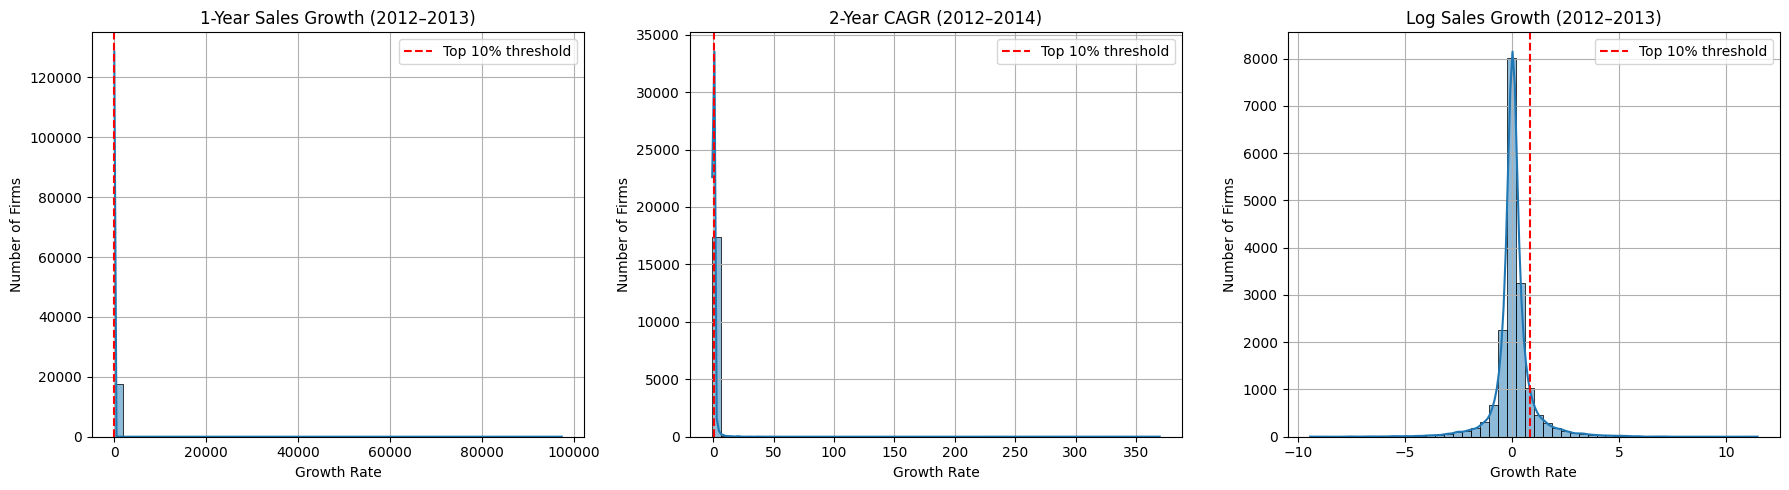

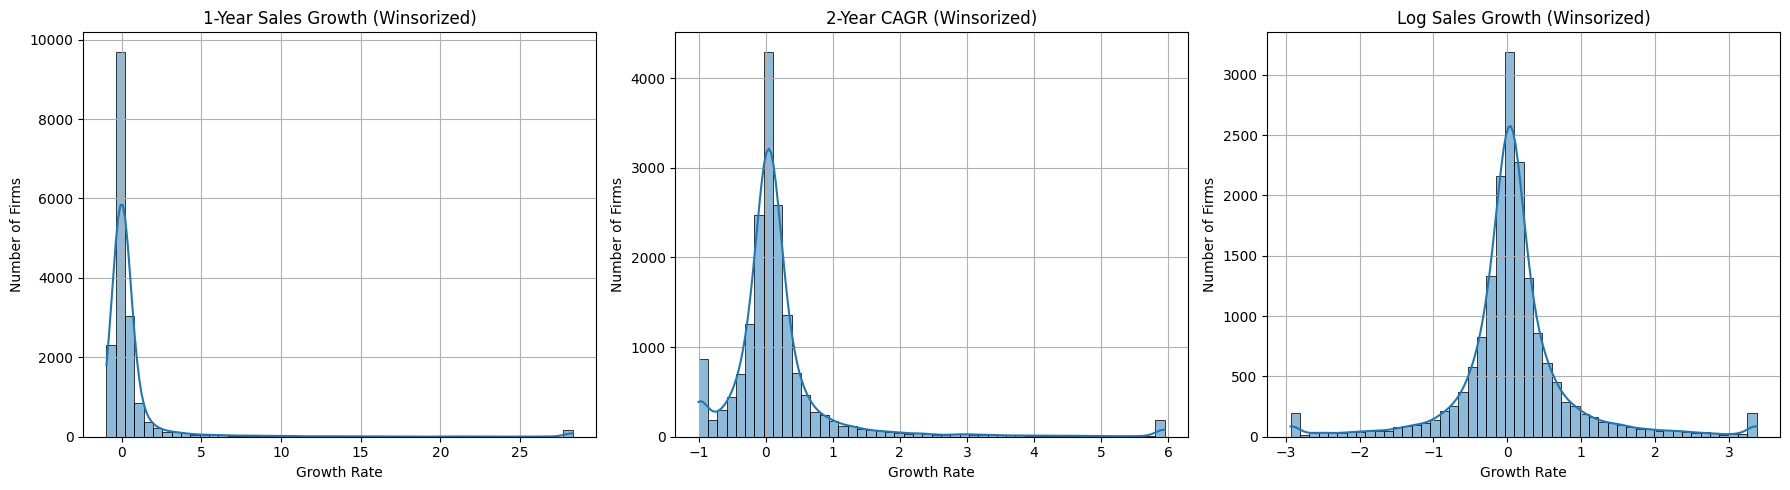

In [16]:
# Setup
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Titles and variables
growth_metrics = {
    'growth_12_13': '1-Year Sales Growth (2012–2013)',
    'cagr_12_14': '2-Year CAGR (2012–2014)',
    'log_growth_12_13': 'Log Sales Growth (2012–2013)'
}

# Plot each
for ax, (col, title) in zip(axes, growth_metrics.items()):
    sns.histplot(sales_pivot[col], bins=50, kde=True, ax=ax)
    threshold = sales_pivot[col].quantile(0.9)
    ax.axvline(threshold, color='red', linestyle='--', label='Top 10% threshold')
    ax.set_title(title)
    ax.set_xlabel('Growth Rate')
    ax.set_ylabel('Number of Firms')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# === Visualization of Winsorized Data ===
# Plot histograms of winsorized variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

growth_metrics_win = {
    'growth_12_13_win': '1-Year Sales Growth (Winsorized)',
    'cagr_12_14_win': '2-Year CAGR (Winsorized)',
    'log_growth_12_13_win': 'Log Sales Growth (Winsorized)'
}

for ax, (col, title) in zip(axes, growth_metrics_win.items()):
    sns.histplot(sales_pivot[col], bins=50, kde=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Growth Rate')
    ax.set_ylabel('Number of Firms')
    ax.grid(True)

plt.tight_layout()
plt.show()


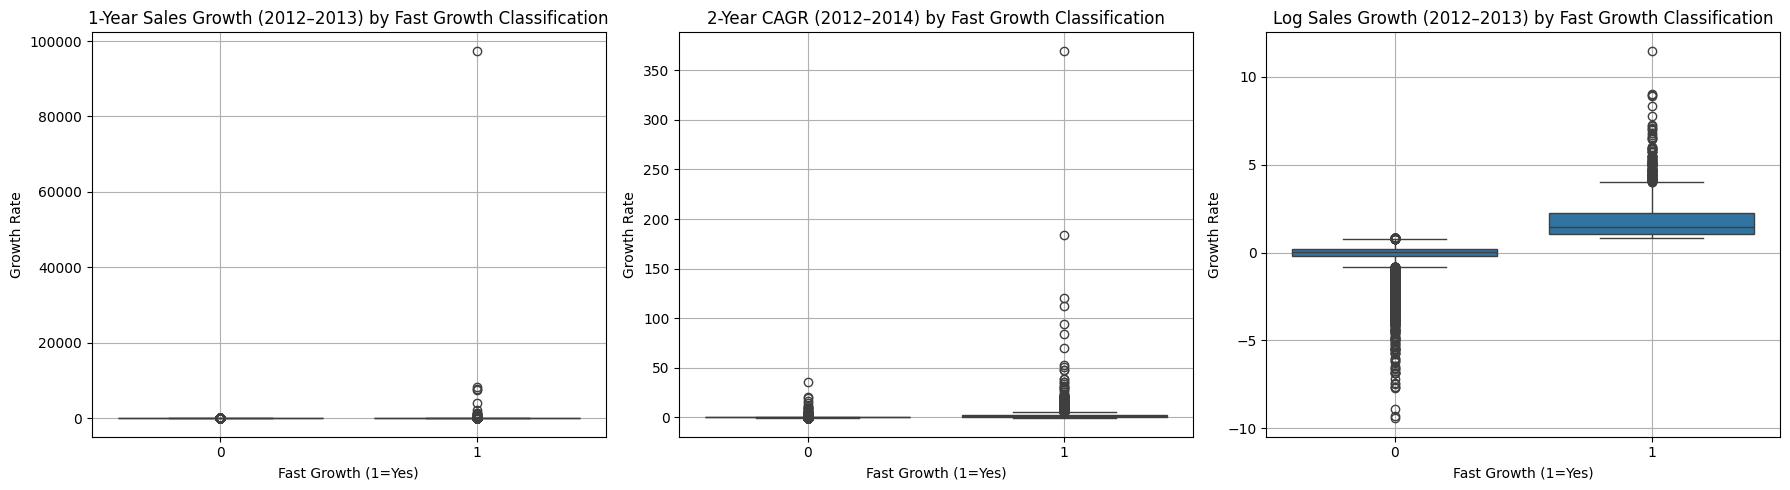

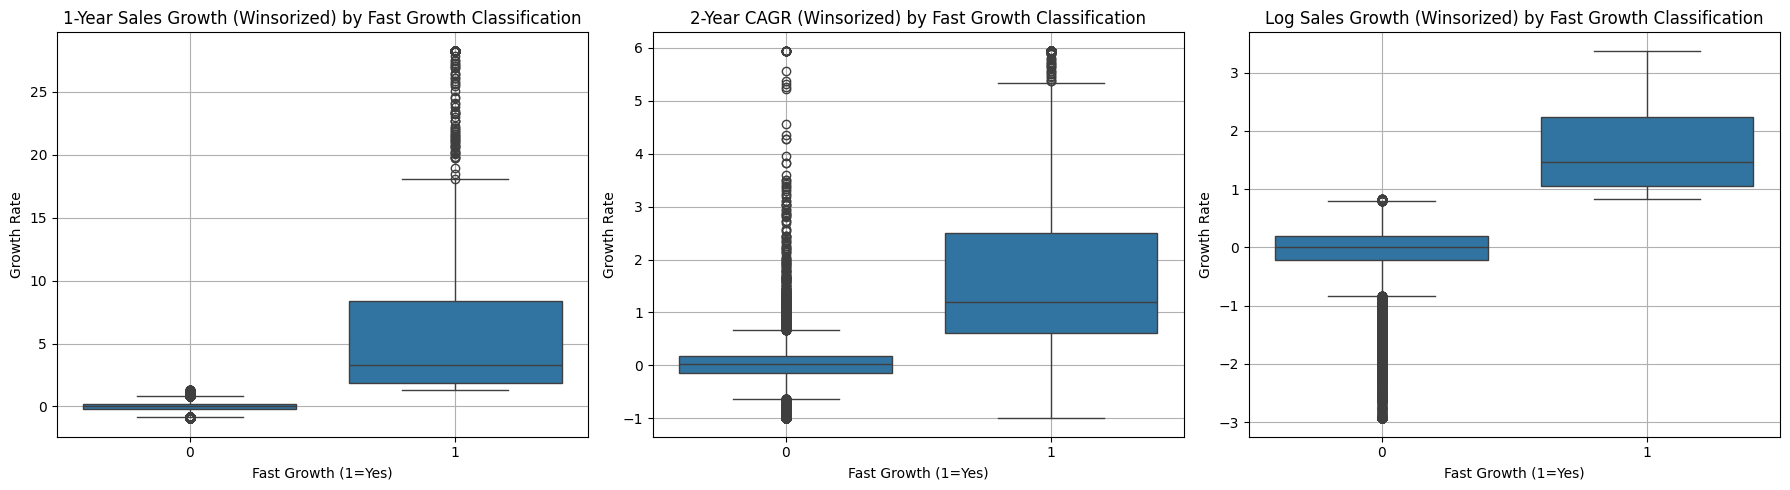

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Define metrics for plotting
growth_metrics = {
    'growth_12_13': '1-Year Sales Growth (2012–2013)',
    'cagr_12_14': '2-Year CAGR (2012–2014)',
    'log_growth_12_13': 'Log Sales Growth (2012–2013)'
}

# Plot each metric with fast growth labels
for ax, (col, title) in zip(axes, growth_metrics.items()):
    sns.boxplot(x='fast_growth_sales', y=col, data=sales_pivot, ax=ax)
    ax.set_title(f"{title} by Fast Growth Classification")
    ax.set_xlabel('Fast Growth (1=Yes)')
    ax.set_ylabel('Growth Rate')
    ax.grid(True)

plt.tight_layout()
plt.show()

# === Boxplots: Fast Growth vs Non-Fast Growth (Winsorized data) ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Plot each metric with fast growth labels
growth_metrics_win = {
    'growth_12_13_win': '1-Year Sales Growth (Winsorized)',
    'cagr_12_14_win': '2-Year CAGR (Winsorized)',
    'log_growth_12_13_win': 'Log Sales Growth (Winsorized)'
}

for ax, (col, title) in zip(axes, growth_metrics_win.items()):
    sns.boxplot(x='fast_growth_sales', y=col, data=sales_pivot, ax=ax)
    ax.set_title(f"{title} by Fast Growth Classification")
    ax.set_xlabel('Fast Growth (1=Yes)')
    ax.set_ylabel('Growth Rate')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [18]:
# Step 1: Reset index on sales_pivot
sales_pivot_reset = sales_pivot.reset_index()

# Step 2: Drop any pre-existing fast_growth_* columns from df_growth
df_growth_clean = df_growth.drop(columns=[
    col for col in df_growth.columns if col.startswith("fast_growth")
], errors='ignore')

# Step 3: Merge with clean df
df_vis = df_growth_clean.merge(sales_pivot_reset, on="comp_id", how="left")

# Step 4: Filter to 2012 base year
df_vis = df_vis[df_vis["year"] == 2012]

# Done! Now no suffixes and clean target columns
df_vis.head()


,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,...,2014,growth_12_13,cagr_12_14,log_growth_12_13,growth_12_13_win,cagr_12_14_win,log_growth_12_13_win,fast_growth_sales,fast_growth_cagr,fast_growth_log
0,1001541.0,2012-01-01,2012-12-31,481.481476,9629.629883,1303.703735,0.0,0.000000,0.000000,190566.671875,...,4888.888672,3.615385,1.015326,1.529395,3.615385,1.015326,1.529395,1.0,1.0,1.0
1,1002029.0,2012-01-01,2012-12-31,14929.629883,203885.187500,120444.453125,0.0,0.000000,0.000000,23459.259766,...,216751.859375,-0.684947,-0.563289,-1.155013,-0.684947,-0.563289,-1.155013,0.0,0.0,0.0
2,1011889.0,2012-01-01,2012-12-31,36625.925781,160166.671875,18911.111328,0.0,0.000000,0.000000,933574.062500,...,472859.250000,0.019293,0.044210,0.019109,0.019293,0.044210,0.019109,0.0,0.0,0.0
3,1014183.0,2012-01-01,2012-12-31,12551.851562,199903.703125,8274.074219,0.0,7.407407,7.407407,118229.632812,...,101051.851562,-0.104205,-0.117423,-0.110044,-0.104205,-0.117423,-0.110044,0.0,0.0,0.0
4,1018301.0,2012-01-01,2012-12-31,0.000000,1811.111084,592.592590,0.0,11.111111,11.111111,52155.554688,...,9081.481445,0.256749,0.162310,0.228529,0.256749,0.162310,0.228529,0.0,0.0,0.0


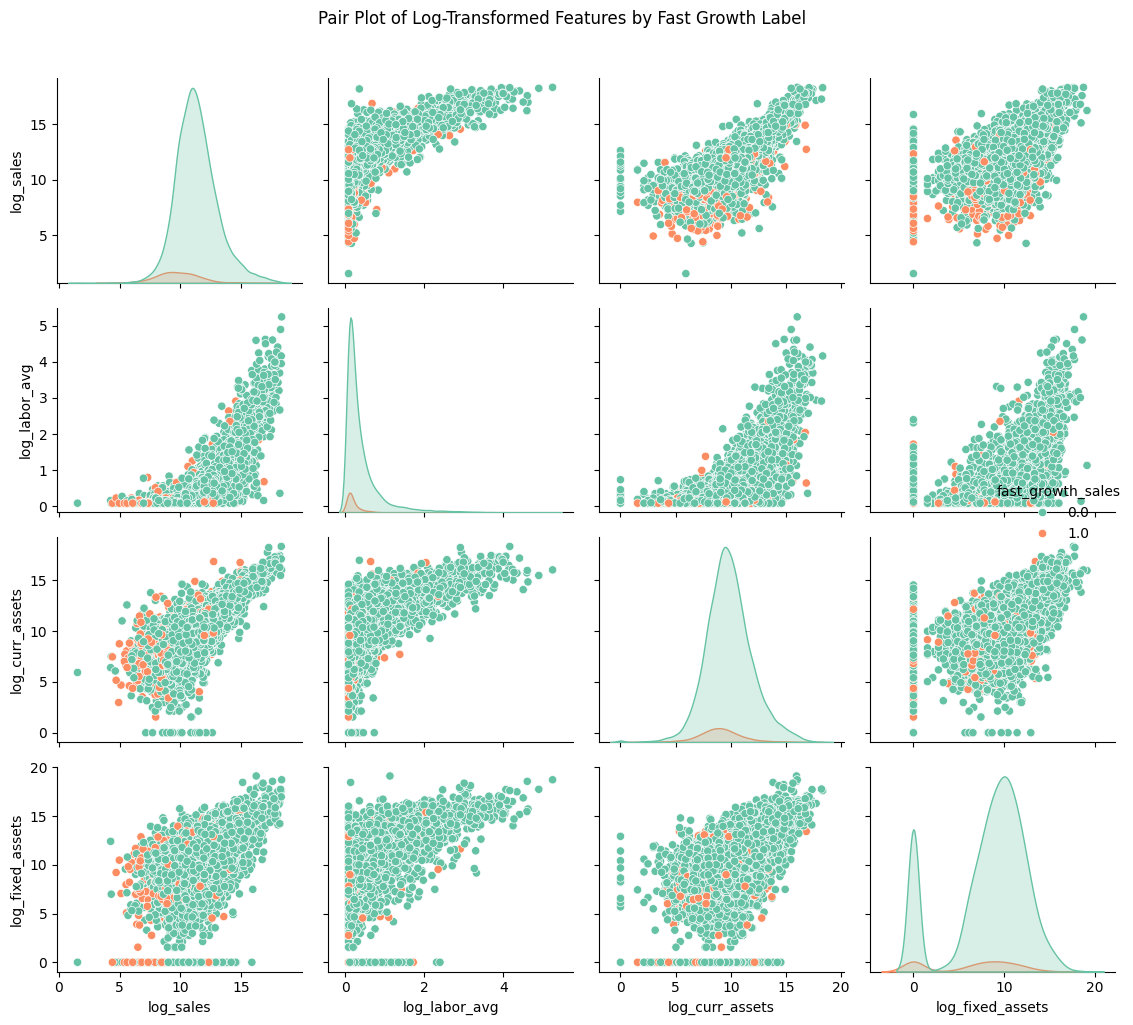

In [19]:
# Keep all columns, just define the subset you want to log-transform
log_targets = ["sales", "labor_avg", "curr_assets", "fixed_assets"]

# Make sure each is numeric before applying transformation
for col in log_targets:
    df_vis[col] = pd.to_numeric(df_vis[col], errors="coerce")  # ensure numeric
    df_vis[f"log_{col}"] = np.log1p(df_vis[col])               # add log version

# Drop rows with missing values in just the transformed subset and the label
log_cols = [f"log_{col}" for col in log_targets]
df_vis_clean = df_vis.dropna(subset=log_cols + ["fast_growth_sales"])
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_vis_clean, vars=log_cols, hue="fast_growth_sales", palette="Set2")
plt.suptitle("Pair Plot of Log-Transformed Features by Fast Growth Label", y=1.02)
plt.tight_layout()
plt.show()


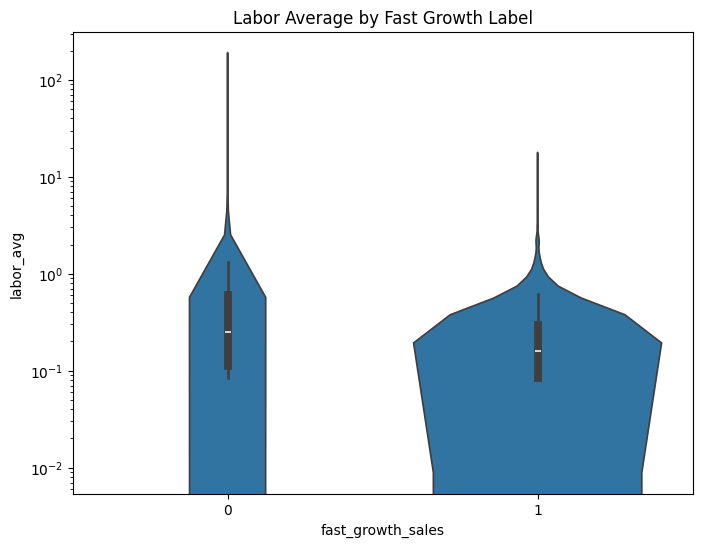

In [20]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='fast_growth_sales', y='labor_avg', data=df_model)
plt.title("Labor Average by Fast Growth Label")
plt.yscale("log")
plt.show()


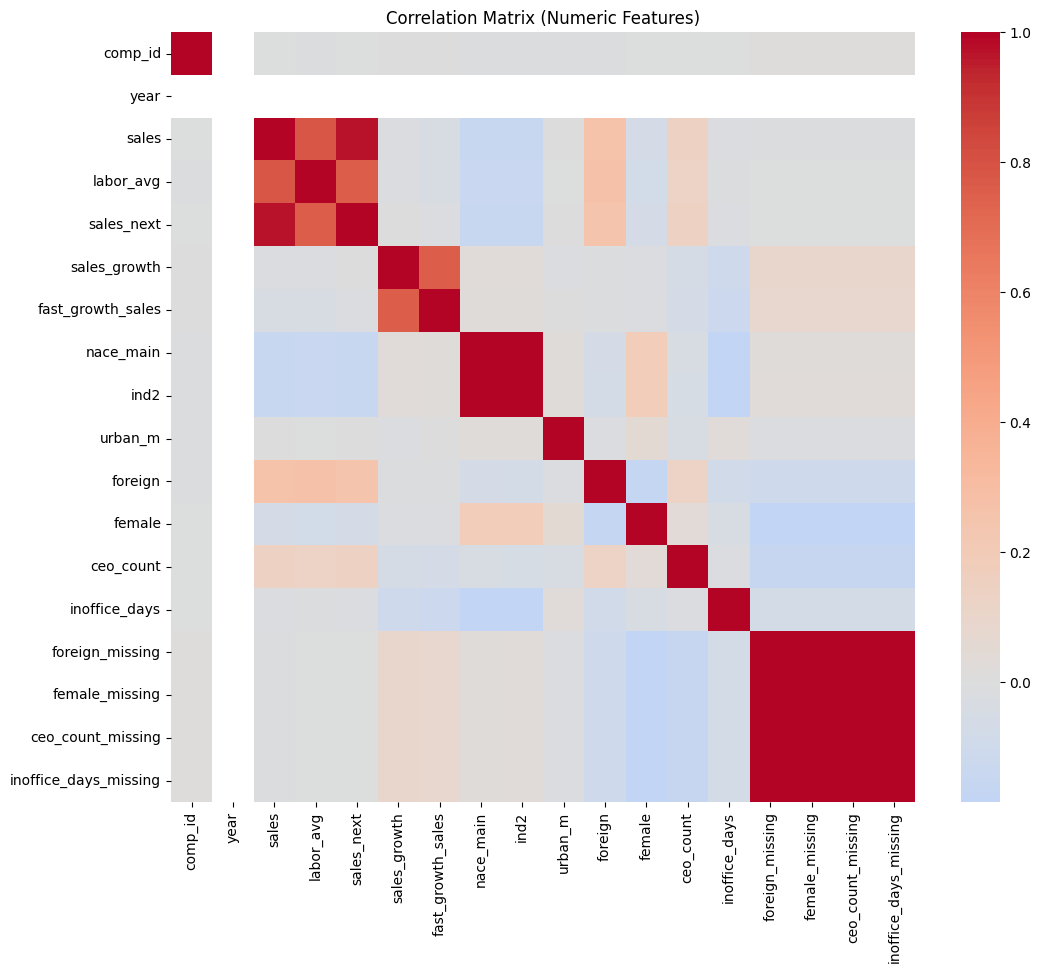

In [21]:
plt.figure(figsize=(12, 10))
corr = df_model.select_dtypes(include=np.number).corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()


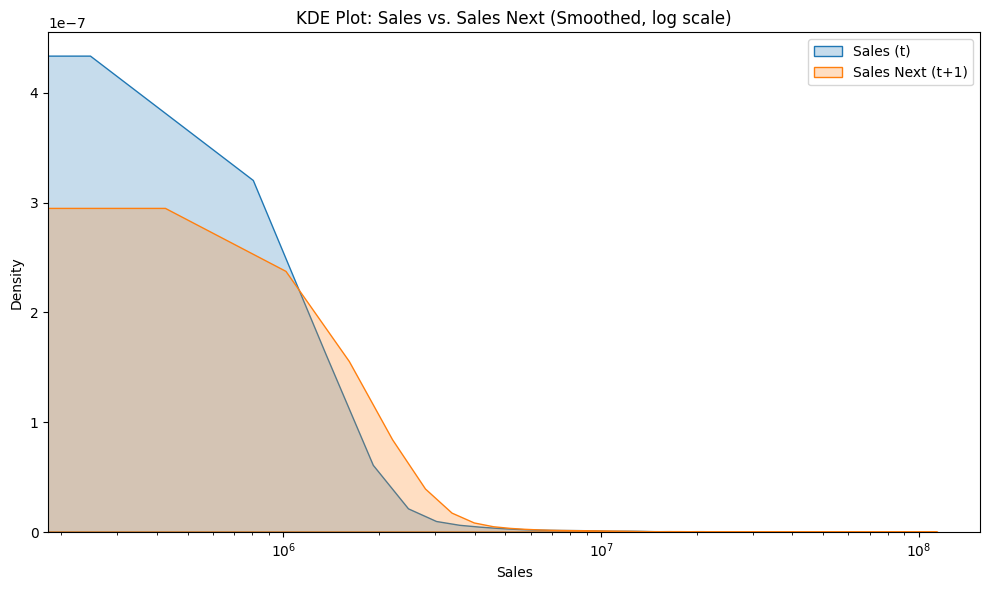

In [22]:


plt.figure(figsize=(10, 6))

sns.kdeplot(df_vis["sales"], label="Sales (t)", shade=True, bw_adjust=1.5)
sns.kdeplot(df_vis["sales_next"], label="Sales Next (t+1)", shade=True, bw_adjust=2)

plt.xscale("log")
plt.title("KDE Plot: Sales vs. Sales Next (Smoothed, log scale)")
plt.xlabel("Sales")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


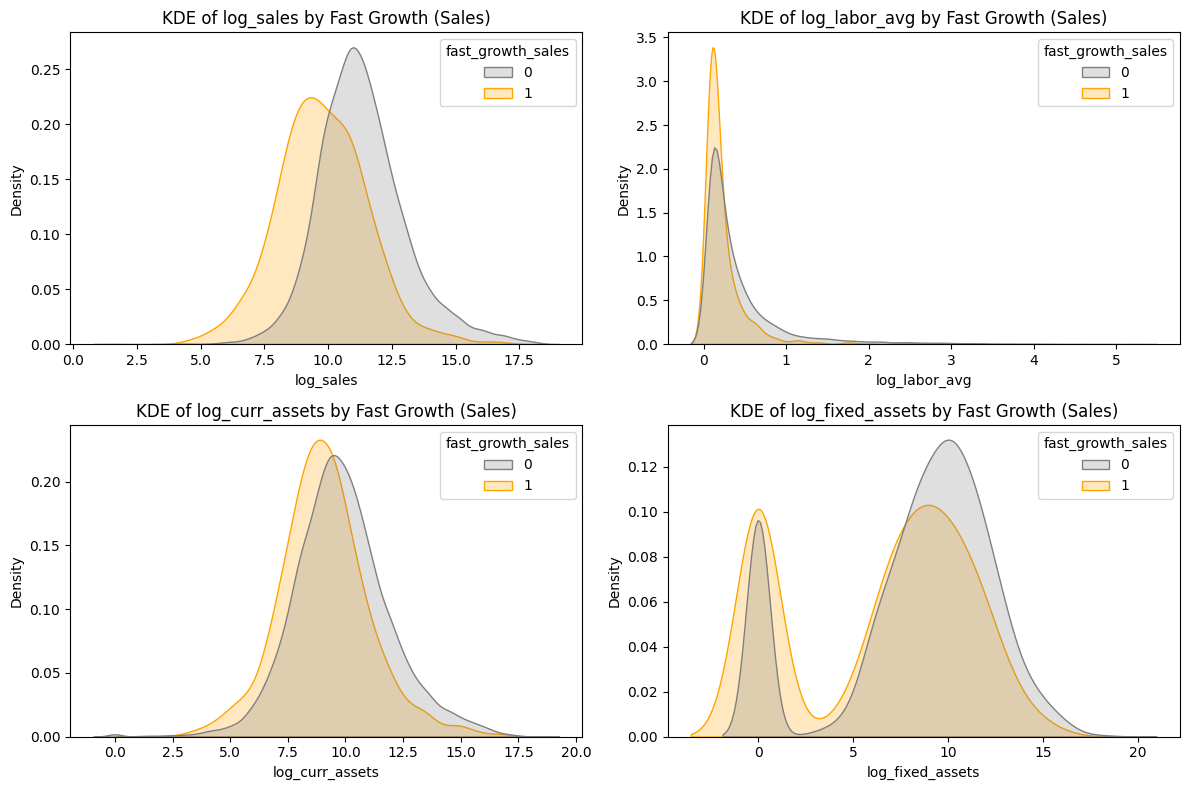

In [23]:
df_vis_clean["fast_growth_sales"] = df_vis_clean["fast_growth_sales"].astype(int)
df_vis_clean = df_vis_clean.dropna(subset=["fast_growth_sales"])

palette = {0: "gray", 1: "orange"}

# KDE plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i, col in enumerate(log_cols):
    sns.kdeplot(data=df_vis_clean, x=col, hue="fast_growth_sales",
                fill=True, common_norm=False, palette=palette, ax=axes[i])
    axes[i].set_title(f"KDE of {col} by Fast Growth (Sales)")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")
plt.tight_layout()
plt.show()



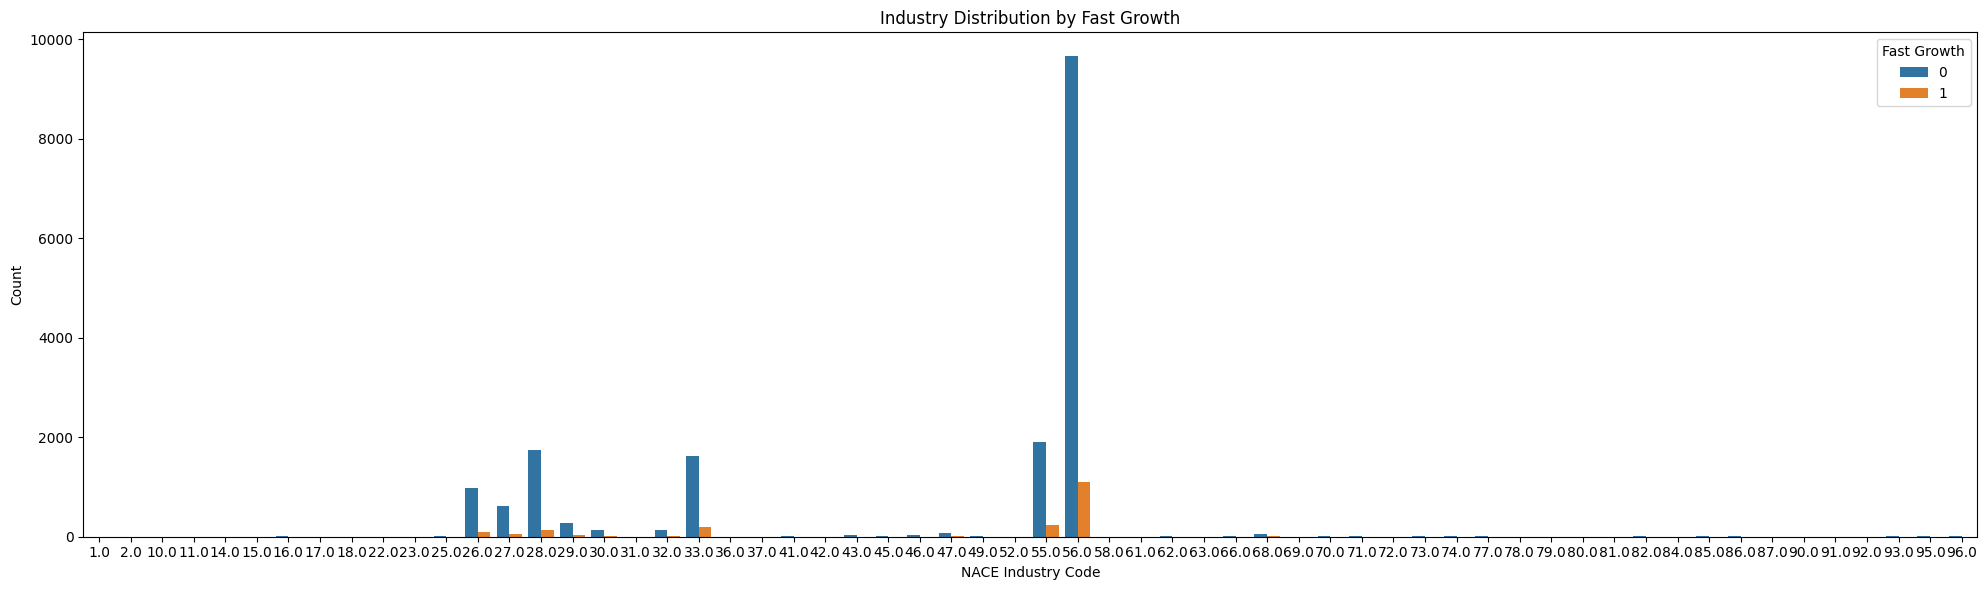

In [28]:
plt.figure(figsize=(20, 6))
sns.countplot(x='ind2', hue='fast_growth_sales', data=df_model)
plt.title("Industry Distribution by Fast Growth")
plt.legend(title='Fast Growth')
plt.xlabel("NACE Industry Code")
plt.ylabel("Count")
plt.tight_layout()

plt.show()


# Models: 

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, brier_score_loss, classification_report
from sklearn.model_selection import train_test_split

# ---------------------------------------------
# Step 1: Define Features and Target
# ---------------------------------------------
X = df_model.drop(columns=["fast_growth_sales", "comp_id", "year", "sales_growth", "sales_next"])
y = df_model["fast_growth_sales"]

# ---------------------------------------------
# Step 2: Define Column Types
# ---------------------------------------------
cat_cols = ['region_m', 'nace_main']
num_cols = [col for col in X.columns if col not in cat_cols]

# ---------------------------------------------
# Step 3: Preprocessing with Imputation
# ---------------------------------------------
# Pipeline for numeric: impute + scale
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline for categorical: impute + one-hot
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

# Combine pipelines
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# ---------------------------------------------
# Step 4: Split Data
# ---------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------------------------
# Step 5: Define Full Pipeline with Logistic Regression
# ---------------------------------------------
logit_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

# ---------------------------------------------
# Step 6: Fit, Predict, Evaluate
# ---------------------------------------------
logit_pipeline.fit(X_train, y_train)
y_pred_logit = logit_pipeline.predict(X_test)
y_prob_logit = logit_pipeline.predict_proba(X_test)[:, 1]

# ---------------------------------------------
# Step 7: Evaluation
# ---------------------------------------------
print("📌 Logistic Regression Results")
print(f"AUC: {roc_auc_score(y_test, y_prob_logit):.3f}")
print(f"Brier Score: {brier_score_loss(y_test, y_prob_logit):.3f}")
print(classification_report(y_test, y_pred_logit, digits=3))


📌 Logistic Regression Results
AUC: 0.699
Brier Score: 0.086
              precision    recall  f1-score   support

           0      0.900     1.000     0.947      3501
           1      0.000     0.000     0.000       389

    accuracy                          0.900      3890
   macro avg      0.450     0.500     0.474      3890
weighted avg      0.810     0.900     0.853      3890



In [26]:
# ---------------------------------------------
# Define the Pipeline
# ---------------------------------------------
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),  # uses the same one we defined for logit
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        n_jobs=-1
    ))
])

# ---------------------------------------------
# Fit, Predict, Evaluate
# ---------------------------------------------
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# ---------------------------------------------
# Evaluation
# ---------------------------------------------
print("Random Forest Results")
print(f"AUC: {roc_auc_score(y_test, y_prob_rf):.3f}")
print(f"Brier Score: {brier_score_loss(y_test, y_prob_rf):.3f}")
print(classification_report(y_test, y_pred_rf, digits=3))


Random Forest Results
AUC: 0.757
Brier Score: 0.082
              precision    recall  f1-score   support

           0      0.911     0.984     0.946      3501
           1      0.486     0.134     0.210       389

    accuracy                          0.899      3890
   macro avg      0.698     0.559     0.578      3890
weighted avg      0.868     0.899     0.873      3890



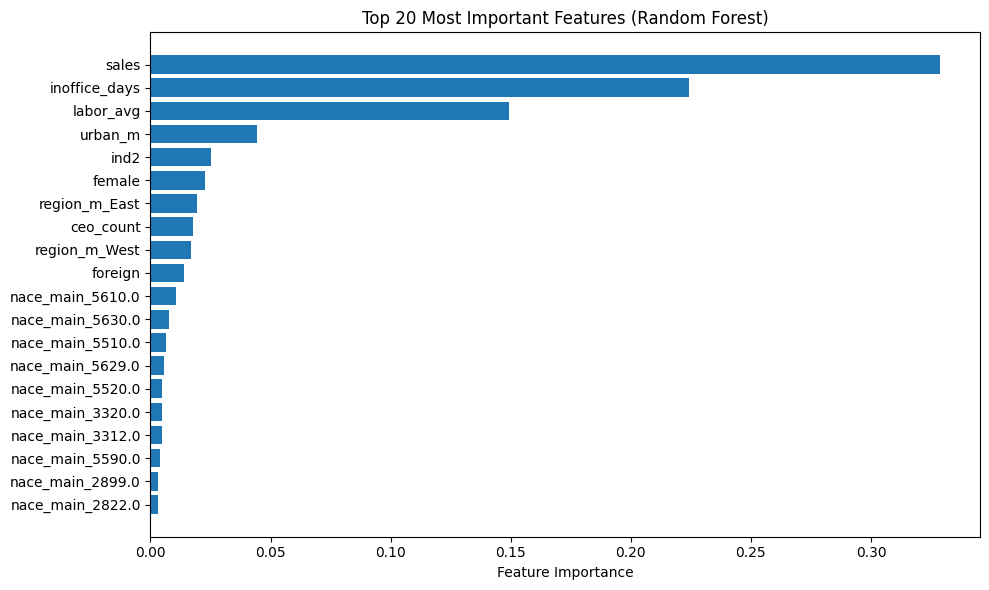

In [27]:
# 1. Extract trained RF model
rf_model = rf_pipeline.named_steps["classifier"]

# 2. Get feature names after preprocessing
#    - numeric: same as num_cols
#    - categorical: one-hot encoded names
ohe = rf_pipeline.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([num_cols, cat_feature_names])

# 3. Get importances and sort
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # descending

# 4. Plot top 20
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances[indices][:top_n][::-1], align="center")
plt.yticks(range(top_n), [all_feature_names[i] for i in indices[:top_n]][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Features (Random Forest)")
plt.tight_layout()
plt.show()


In [31]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [33]:
# L1-penalized Logistic Regression (LASSO)
lasso_clf = LogisticRegressionCV(
    Cs=5,                   # reduce grid size
    cv=3,                   # speed up by reducing folds
    penalty="l1",
    solver="saga",
    scoring="roc_auc",
    max_iter=1000,
    n_jobs=-1,
    random_state=42,
    verbose=1               # show progress in terminal
)

lasso_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", lasso_clf)
])

lasso_pipeline.fit(X_train, y_train)
# Predictions
y_pred_lasso = lasso_pipeline.predict(X_test)
y_prob_lasso = lasso_pipeline.predict_proba(X_test)[:, 1]

# Evaluate
print("LASSO Logistic Regression Results")
print(f"AUC: {roc_auc_score(y_test, y_prob_lasso):.3f}")
print(f"Brier Score: {brier_score_loss(y_test, y_prob_lasso):.3f}")
print(classification_report(y_test, y_pred_lasso, digits=3))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds

Epoch 1, change: 1
Epoch 1, change: 1
Epoch 1, change: 1
Epoch 2, change: 0.32627795
Epoch 2, change: 0.32373889
Epoch 2, change: 0.32847258
Epoch 3, change: 0.18064183
Epoch 3, change: 0.18392534
Epoch 3, change: 0.17790327
Epoch 4, change: 0.1200534
Epoch 4, change: 0.11902864
Epoch 4, change: 0.1180722
Epoch 5, change: 0.085057395
Epoch 5, change: 0.084626697
Epoch 5, change: 0.082287245
Epoch 6, change: 0.061490066
Epoch 6, change: 0.061160511
Epoch 6, change: 0.062822832
Epoch 7, change: 0.046023575
Epoch 7, change: 0.046506622
Epoch 7, change: 0.047141926
Epoch 8, change: 0.036046003
Epoch 8, change: 0.036762225
Epoch 8, change: 0.034889989
Epoch 9, change: 0.031211097
Epoch 9, change: 0.031931351
Epoch 9, change: 0.029434735
Epoch 10, change: 0.02699718
Epoch 10, change: 0.027546269
Epoch 10, change: 0.02537847
Epoch 11, change: 0.023404687
Epoch 11, chan

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.6min finished


LASSO Logistic Regression Results
AUC: 0.703
Brier Score: 0.086
              precision    recall  f1-score   support

           0      0.900     1.000     0.947      3501
           1      0.000     0.000     0.000       389

    accuracy                          0.900      3890
   macro avg      0.450     0.500     0.474      3890
weighted avg      0.810     0.900     0.853      3890



In [34]:
from xgboost import XGBClassifier

xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

print("XGBoost Results")
print(f"AUC: {roc_auc_score(y_test, y_prob_xgb):.3f}")
print(f"Brier Score: {brier_score_loss(y_test, y_prob_xgb):.3f}")
print(classification_report(y_test, y_pred_xgb))


XGBoost Results
AUC: 0.785
Brier Score: 0.079
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      3501
           1       0.50      0.15      0.23       389

    accuracy                           0.90      3890
   macro avg       0.71      0.57      0.59      3890
weighted avg       0.87      0.90      0.87      3890



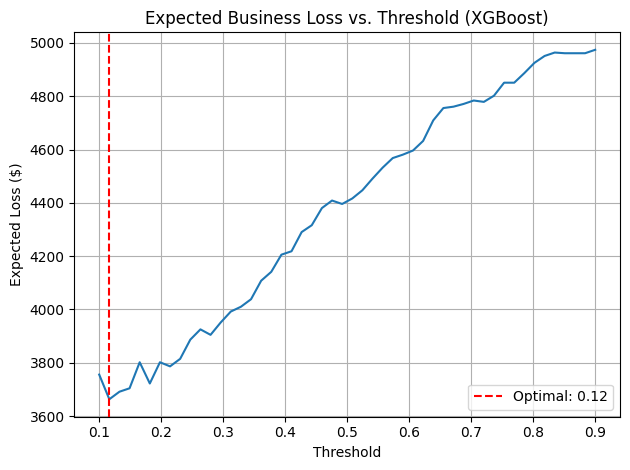

In [37]:
# Optimal Threshold Based on Expected Business Loss:
thresholds = np.linspace(0.1, 0.9, 50)
expected_losses = [
    (np.mean((y_prob_xgb >= t) & (y_test == 0)) * 10000 + 
     np.mean((y_prob_xgb < t) & (y_test == 1)) * 50000)
    for t in thresholds
]

optimal_threshold = thresholds[np.argmin(expected_losses)]

plt.plot(thresholds, expected_losses)
plt.axvline(optimal_threshold, color="red", linestyle="--", label=f"Optimal: {optimal_threshold:.2f}")
plt.title("Expected Business Loss vs. Threshold (XGBoost)")
plt.xlabel("Threshold")
plt.ylabel("Expected Loss ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


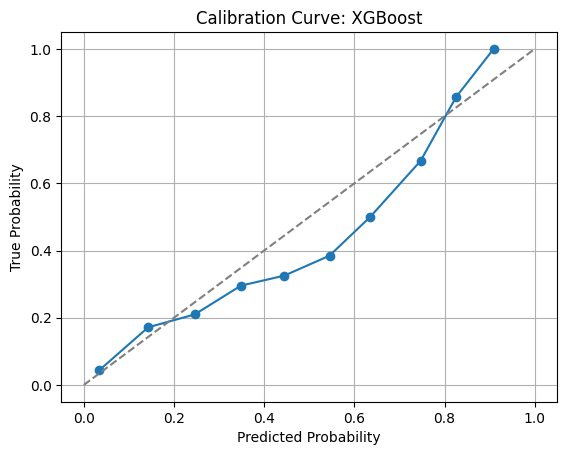

In [38]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_prob_xgb, n_bins=10)

plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("Calibration Curve: XGBoost")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.grid(True)
plt.show()


In [39]:
df_manuf = df_model[df_model["nace_main"].isin([10, 11, 12])]  # adjust based on your NACE structure
df_service = df_model[df_model["nace_main"].isin([56, 95])]    # e.g., food/accommodation/repair

### Model Selection and Evaluation

Four models were evaluated based on statistical performance (AUC, Brier Score), calibration, and business logic via expected loss. LASSO Logistic Regression yielded high accuracy but entirely failed to detect any fast-growing firms (0% recall), which is unacceptable in our context where missing a fast grower represents a significant opportunity cost. Its over-regularization likely suppressed all positive class predictions.

XGBoost, in contrast, achieved the highest AUC (0.785), best calibration (verified via calibration plots), and lowest Brier score (0.079). Most importantly, by tuning the classification threshold to minimize expected business loss ($50K per missed grower vs $10K per false alarm), the optimal threshold of 0.12 reduced expected loss to approximately $3,600. 

Based on these findings, we select **XGBoost with a tuned threshold of 0.12** as the final model. It provides a calibrated probability output, supports actionable decision-making, and minimizes potential misclassification costs.




# Then re-run the full pipeline for each subset using your best model (XGB or LASSO)


In [ ]:
summary_df = pd.DataFrame({
    "Model": ["Logistic", "Random Forest", "LASSO", "XGBoost"],
    "AUC": [
        roc_auc_score(y_test, y_prob_logit),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_lasso),
        roc_auc_score(y_test, y_prob_xgb)
    ],
    "Brier": [
        brier_score_loss(y_test, y_prob_logit),
        brier_score_loss(y_test, y_prob_rf),
        brier_score_loss(y_test, y_prob_lasso),
        brier_score_loss(y_test, y_prob_xgb)
    ],
    "Expected Loss": [
        np.nan,  # to be computed
        np.nan,
        np.nan,
        np.min(expected_losses)  # XGB shown here as example
    ]
})
summary_df